In [1]:
%load_ext autoreload
%autoreload 2

from typing import Literal, Dict, Any, Tuple
from itertools import combinations
from tqdm import tqdm
from dataclasses import dataclass, asdict, field
from itertools import product, combinations
from tqdm import tqdm
import seaborn as sns
from pprint import pprint

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import ListedColormap
from pgmpy.models.MarkovNetwork import MarkovNetwork
from pgmpy.models import DiscreteBayesianNetwork

from tabicl.prior.dataset import PriorDataset

from gtfm.graph.scm import get_graph
from gtfm.viz.graph import draw_scms
from gtfm.graph.moral_marg import old_check
from gtfm.utils.adj import remove_axis
from gtfm.viz.imshow import imshow
from gtfm.prior.hparams import set_scm_hparams, PriorConfig
from gtfm.utils.misc import clipboard

### Visaluze graphs

In [ ]:
# def load_prior_data(prior_config: PriorConfig):
#     dataset = PriorDataset(**prior_config.to_dict())
#     xs, ys, ds, seq_lens, train_sizes, adjs, priors = dataset.prior.get_batch()
#     (
#         graphs_full, 
#         graphs_moma, 
#         graphs_lean_moma,
        
#         nodelists,
#         densities,
#     ) = map(list, zip(*[(
#         prior.graph_full, 
#         prior.graph_moma, 
#         prior.graph_lean_moma,
        
#         prior.graph_full.graph['nodes_include'],
#         prior.density,
#     ) for prior in priors]))

#     n_graphs = len(graphs_full)

#     prior_config.priors = priors
#     prior_config.graphs_full = graphs_full
#     prior_config.graphs_moma = graphs_moma
#     prior_config.graphs_lean_moma = graphs_lean_moma
#     prior_config.nodelists = nodelists
#     prior_config.n_graphs = n_graphs
#     prior_config.densities = densities

#     return prior_config, priors

# hidden_dims = [3, 20, 50]
# n_featureses = [5, 10, 20]
# combs = list(product(hidden_dims, n_featureses))

In [11]:
# prior_infos = {}

# for hidden_dim, n_features in tqdm(combs):
#     prior_config = PriorConfig(
#         custom_scm_fixed_hp = {
#             'is_causal': True,
#             'in_clique': False,
#             'hidden_dim': hidden_dim,
#         },
#         min_features=n_features,
#         max_features=n_features,
#         dataset_kwargs=dict(
#             batch_size_per_gp = 1,
#         )
#     )

#     prior_info, _ = load_prior_data(prior_config = prior_config)
#     prior_infos[(hidden_dim, n_features)] = prior_info


# prior_info = PriorConfig(
#     custom_scm_fixed_hp = {
#         'is_causal': True,
#         'in_clique': False,
#         'hidden_dim': 3,
#     },
# )

# # prior_info = load_prior_data(prior_info)




































100%|██████████| 256/256 [00:01<00:00, 146.73it/s]

100%|██████████| 256/256 [00:01<00:00, 151.94it/s]

 22%|██▏       | 2/9 [00:07<00:26,  3.73s/it]t/s]


KeyboardInterrupt: 

 23%|██▎       | 60/256 [00:13<00:01, 116.40it/s]

In [ ]:
bins = np.linspace(0, 1, 11)
nrows, ncols = len(hidden_dims), len(n_featureses)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows), squeeze=False, sharex =True, sharey=True)

for ax, (hidden_dim, n_features) in zip(axs.flatten(), combs, strict=True):
    prior_info = prior_infos[(hidden_dim, n_features)]
    ax.hist(prior_info.densities, bins=bins)
    ax.set_title(f"{hidden_dim = }\n{n_features = }")
fig.supxlabel('Density (% of possible edges)')
fig.supylabel('Count')
plt.tight_layout()
plt.show()

# fig, ax = plt.subplots(figsize=(6,4))
# ax.hist(prior_info.densities, bins=10)
# ax.set(
#     title='Density of moralized and marginalized graphs',
#     xlabel=r'Density (% of possible edges)',
#     ylabel='Count',
# )
# plt.show()

In [ ]:
for ax, (hidden_dim, n_features) in zip(axs.flatten(), combs, strict=True):
    prior_info = prior_infos[(hidden_dim, n_features)]
    
    random_selection = np.random.choice(prior_info.n_graphs, size=12, replace=False)

    draw_scms(
        graphs = [prior_info.graphs_full[i] for i in random_selection] + [prior_info.graphs_lean_moma[i] for i in random_selection], 
        suptitle=f"{hidden_dim = }\n{n_features = }",
        nodelists = [None for i in random_selection] + [prior_info.nodelists[i] for i in random_selection],
        pos = ['layer' for i in random_selection] + ['circular' for i in random_selection],
        n_rows=2,
    )
    
    # draw_scms(
    #     graphs = [prior_info.graphs_full[i] for i in random_selection], 
    #     suptitle=f"{hidden_dim = }\n{n_features = }",
    #     # nodelists = [None for i in random_selection],
    #     # pos = 'circular',
    # )

    # draw_scms(
    #     graphs = [prior_info.graphs_lean_moma[i] for i in random_selection], 
    #     suptitle=f"{hidden_dim = }\n{n_features = }",
    #     nodelists = [prior_info.nodelists[i] for i in random_selection],
    #     pos = 'circular',
    # )


### More analysis

In [2]:
prior_config_default = PriorConfig(
    dataset_kwargs=dict(
        batch_size = 256,
        batch_size_per_gp = 1,
    )
)

# prior_config_reject = PriorConfig(
#     max_density = 0.999,
#     dataset_kwargs=dict(
#         batch_size = 1024,
#         batch_size_per_gp = 1,
#     )
# )

prior_config_cut1 = PriorConfig(
    min_features=20,
    custom_scm_sampled_hp=dict(
        hidden_dim = {
            "distribution": "meta_trunc_norm_log_scaled",
            "max_mean": 20,
            "min_mean": 5,
            "round": True,
            "lower_bound": 4,
        },
    ),
    dataset_kwargs=dict(
        batch_size = 256,
        batch_size_per_gp = 1,
    )
)

prior_config = prior_config_default
pprint(prior_config)

PriorConfig(min_features=2,
            max_features=100,
            custom_scm_fixed_hp={'in_clique': False, 'is_causal': True},
            custom_scm_sampled_hp={},
            scm_fixed_hp={'balanced': False,
                          'cat_prob': 0.2,
                          'in_clique': False,
                          'is_causal': True,
                          'max_categories': inf,
                          'mix_probs': (0.7, 0.3),
                          'multiclass_ordered_prob': 0.0,
                          'permute_features': True,
                          'permute_labels': True,
                          'scale_by_max_features': False,
                          'tree_depth_lambda': 0.5,
                          'tree_model': 'xgboost',
                          'tree_n_estimators_lambda': 0.5},
            scm_sampled_hp={'block_wise_dropout': {'choice_values': [True,
                                                                     False],
                   

In [3]:
dataset = PriorDataset(**prior_config.to_dict())
*_, priors = dataset.prior.get_batch()

100%|██████████| 256/256 [01:01<00:00,  4.15it/s]


In [4]:
df = pd.DataFrame([
    {
        'num_features': p.num_features,
        'num_outputs': p.num_outputs,
        'is_causal': p.is_causal,
        'y_is_effect': p.y_is_effect,
        'in_clique': p.in_clique,
        'hidden_dim': p.hidden_dim,
        'num_layers': p.num_layers,
        'block_wise_dropout': p.block_wise_dropout,
        'mlp_dropout_prob': p.mlp_dropout_prob,
        'density': p.density,

        'graph_full': p.graph_full,
        'graph_moma': p.graph_moma,
        'graph_lean_moma': p.graph_lean_moma,
        'nodelist': p.graph_full.graph['nodes_include'],
    } 
    for p in priors
])

print(df.shape, df.dtypes, sep = '\n')

(256, 14)
num_features            int64
num_outputs             int64
is_causal                bool
y_is_effect              bool
in_clique                bool
hidden_dim              int64
num_layers              int64
block_wise_dropout       bool
mlp_dropout_prob      float64
density               float64
graph_full             object
graph_moma             object
graph_lean_moma        object
nodelist               object
dtype: object


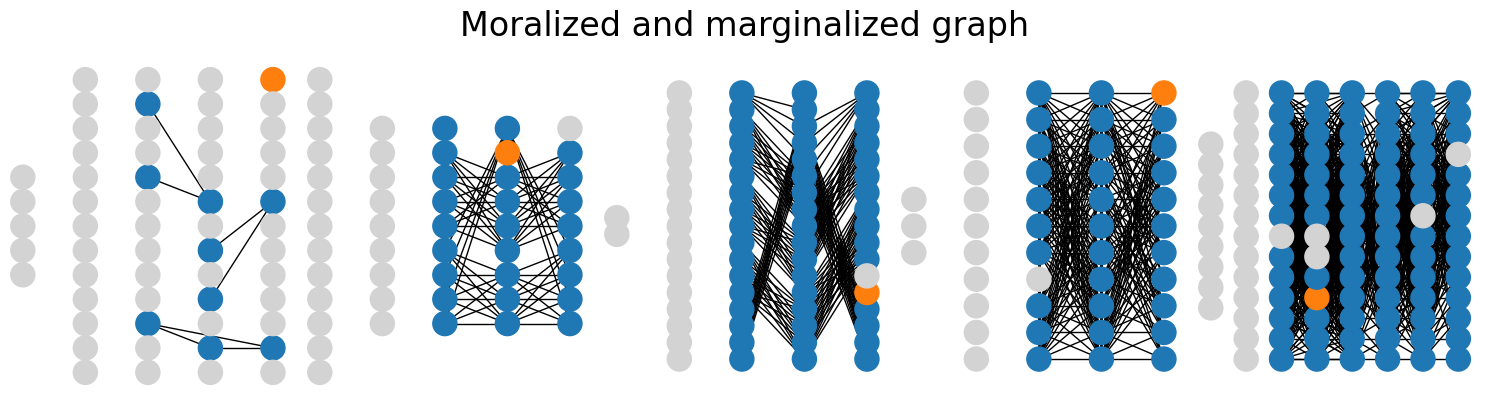

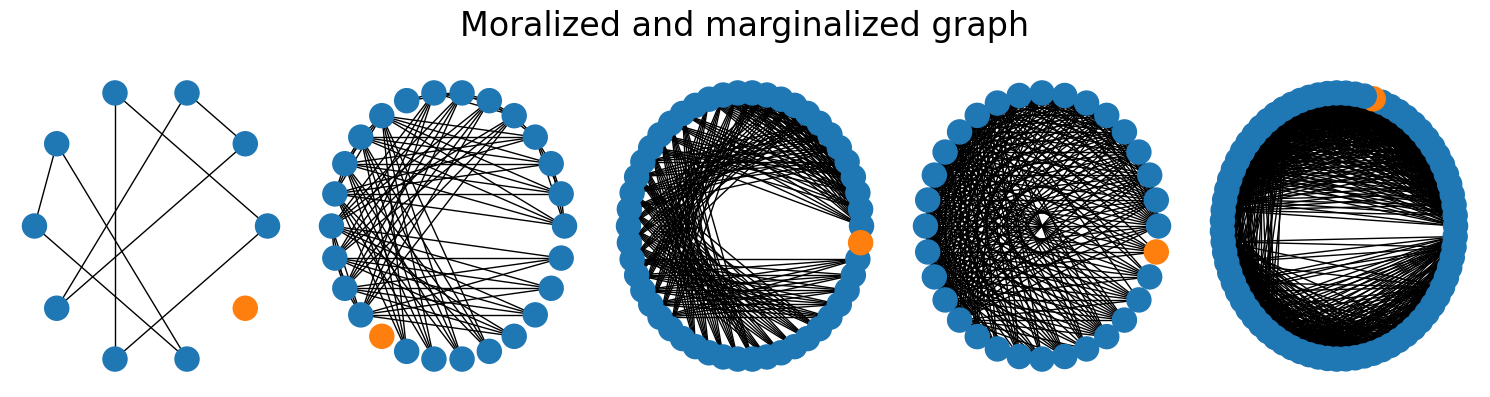

[0.20000000298023224,
 0.2830769121646881,
 0.23591837286949158,
 0.6068548560142517,
 0.3810451030731201]

In [5]:
mask_select = df['density'] < 0.7
mask_select = mask_select & mask_select.index.isin(np.random.choice(mask_select[mask_select].index, size=5, replace=False))

draw_scms(
    df.loc[mask_select, 'graph_moma'].tolist(),
    suptitle='Moralized and marginalized graph',
    # nodelists = df.loc[mask_select, 'nodelist'].tolist(),
    # pos = 'circular',
)

draw_scms(
    df.loc[mask_select, 'graph_lean_moma'].tolist(),
    suptitle='Moralized and marginalized graph',
    nodelists = df.loc[mask_select, 'nodelist'].tolist(),
    pos = 'circular',
)

df.loc[mask_select, 'density'].tolist()

In [6]:
drop_cols = ['graph_full', 'graph_moma', 'graph_lean_moma', 'nodelist']
for col in df.columns:
    if col in drop_cols: continue
    if df[col].nunique() <= 1:
        drop_cols.append(col)

df_encoded = df_plot = df.drop(columns=drop_cols).copy()

/Users/elias/anaconda3/envs/tfm/lib/python3.11/site-packages/seaborn/distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  baselines[cols] = curves[cols].shift(1, axis=1).fillna(0)
/Users/elias/anaconda3/envs/tfm/lib/python3.11/site-packages/seaborn/distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  baselines[cols] = curves[cols].shift(1, axis=1).fillna(0)
/Users/elias/anaconda3/envs/tfm/lib/python3.11/site-packages/seaborn/distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  

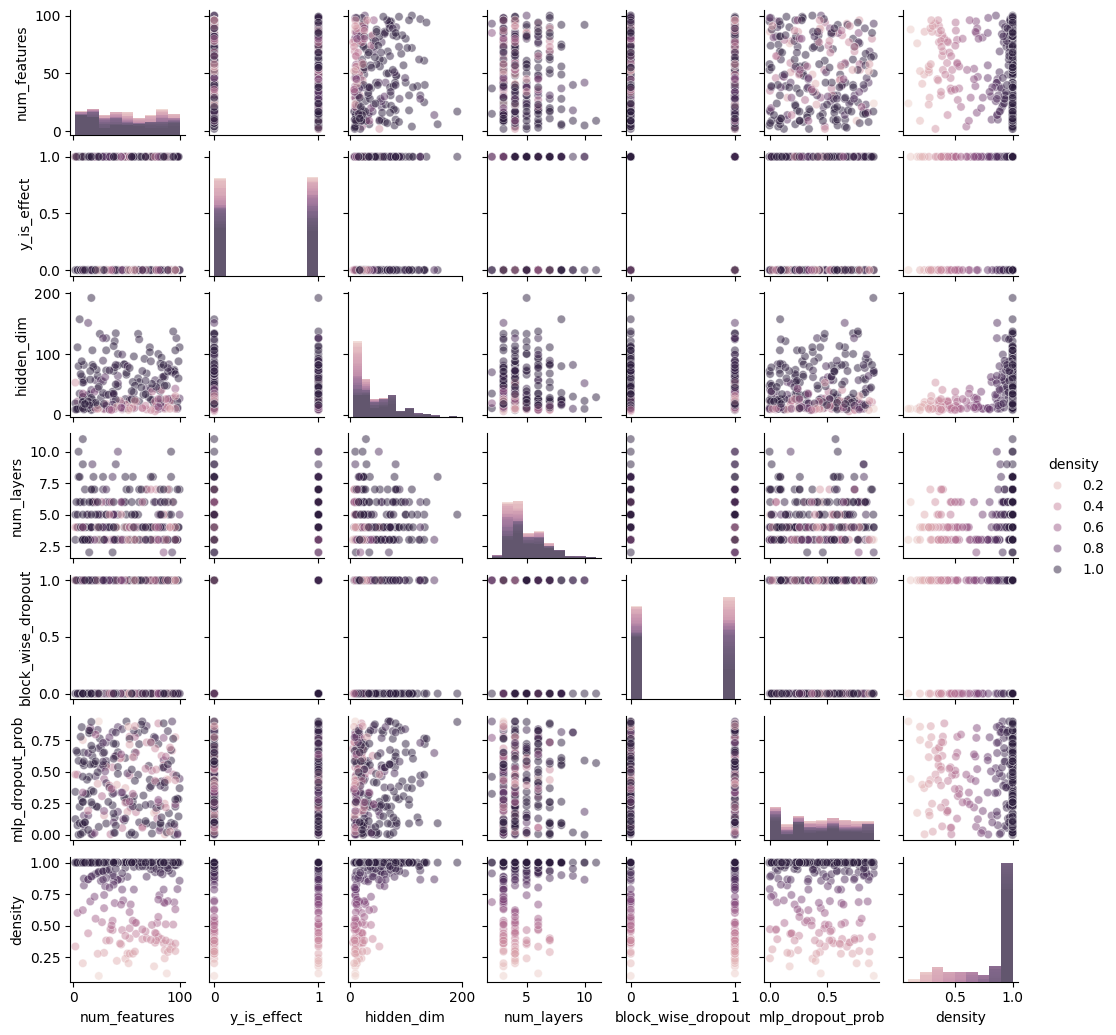

In [7]:
# g = sns.pairplot(
#     df_plot,
#     height = 1.5,
#     plot_kws={'alpha':0.5}
# )

g = sns.pairplot(
    df_plot,
    hue='density',
    vars = df_plot.columns.tolist(),
    diag_kind = 'hist',
    height = 1.5,
    plot_kws={'alpha':0.5},
    diag_kws={'multiple': 'stack', 'linewidth': 0} 
)

Observations:
- Density is high when num_features is low, could be because when num_features is low, relatively many nodes are marginalized out, leading to denser graphs.
- 

In [8]:
# import plotly.express as px
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import math
from sklearn.inspection import partial_dependence

In [9]:
X = df_encoded.drop(columns=['density'])
y = df_encoded['density']


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

y_pred = model.predict(X)
r2_score_val, mse = r2_score(y, y_pred), mean_squared_error(y, y_pred)
print(f'{r2_score_val = }, {mse = }')

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_interaction_values = explainer.shap_interaction_values(X)

r2_score_val = 0.9361700118906143, mse = 0.004274835364946809


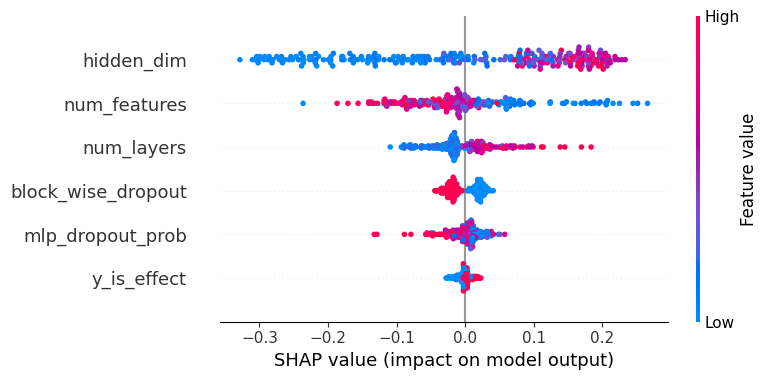

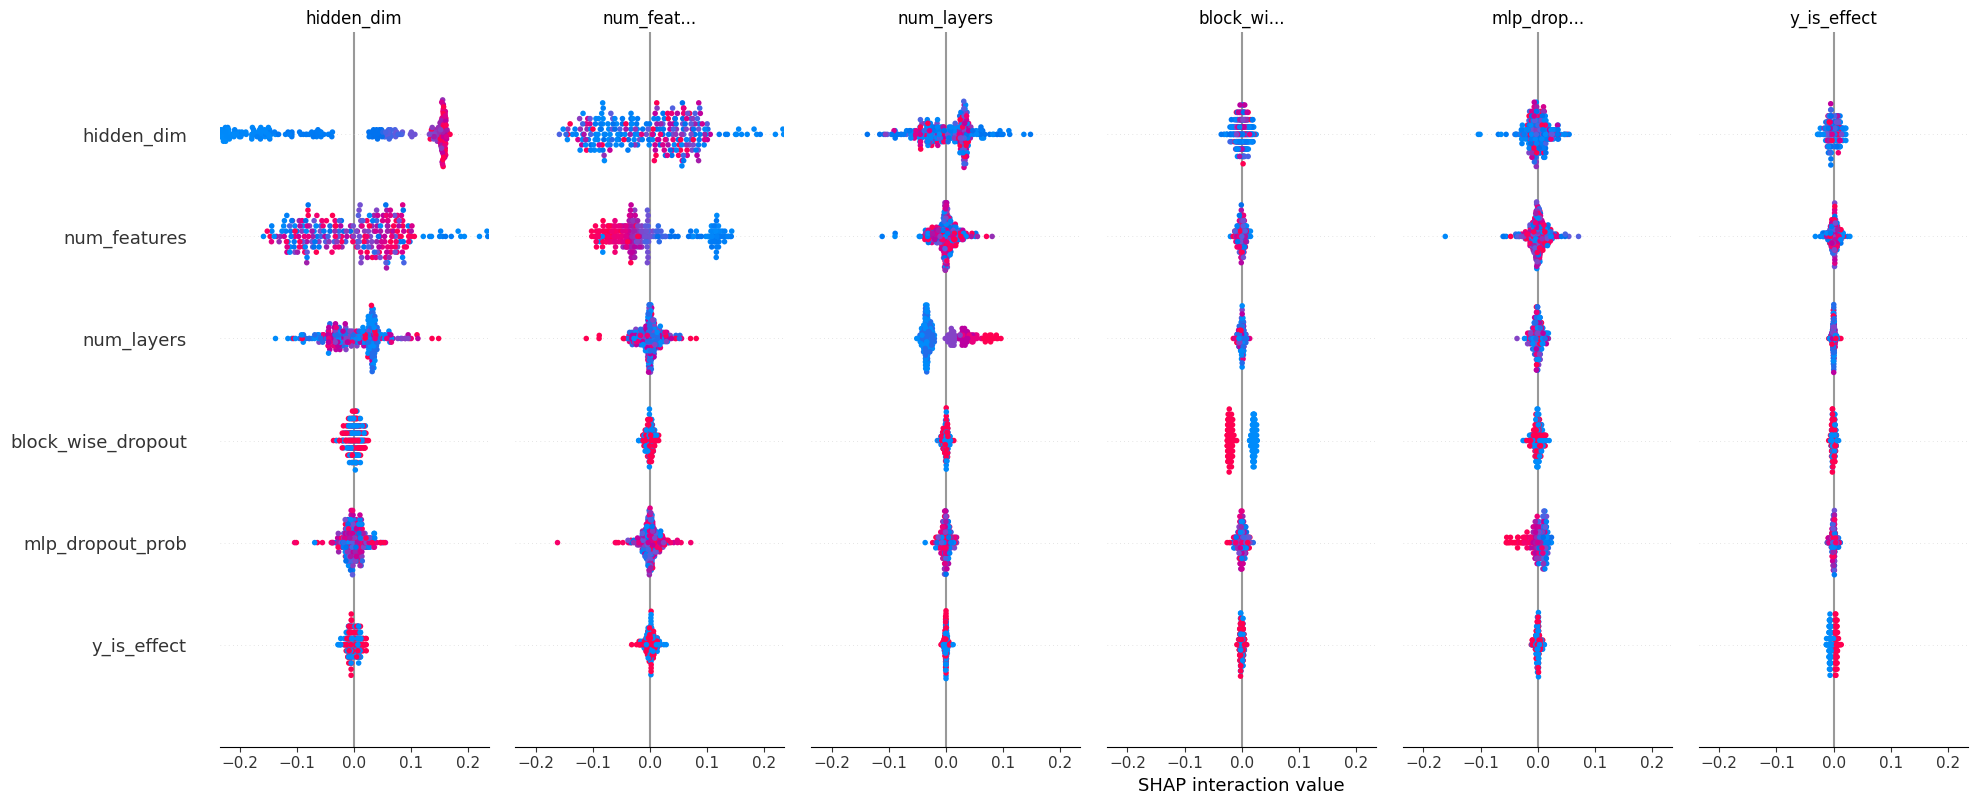

In [10]:
shap.summary_plot(shap_values, X, show=False)
# plt.title("SHAP Feature Importance (Beeswarm)")
# plt.tight_layout()
plt.show()


shap.summary_plot(shap_interaction_values, X, show=False)
fig = plt.gcf()
fig.set_size_inches(25, 8)
# plt.title("SHAP Interaction Feature Importance (Beeswarm)")
# plt.tight_layout()
plt.show()

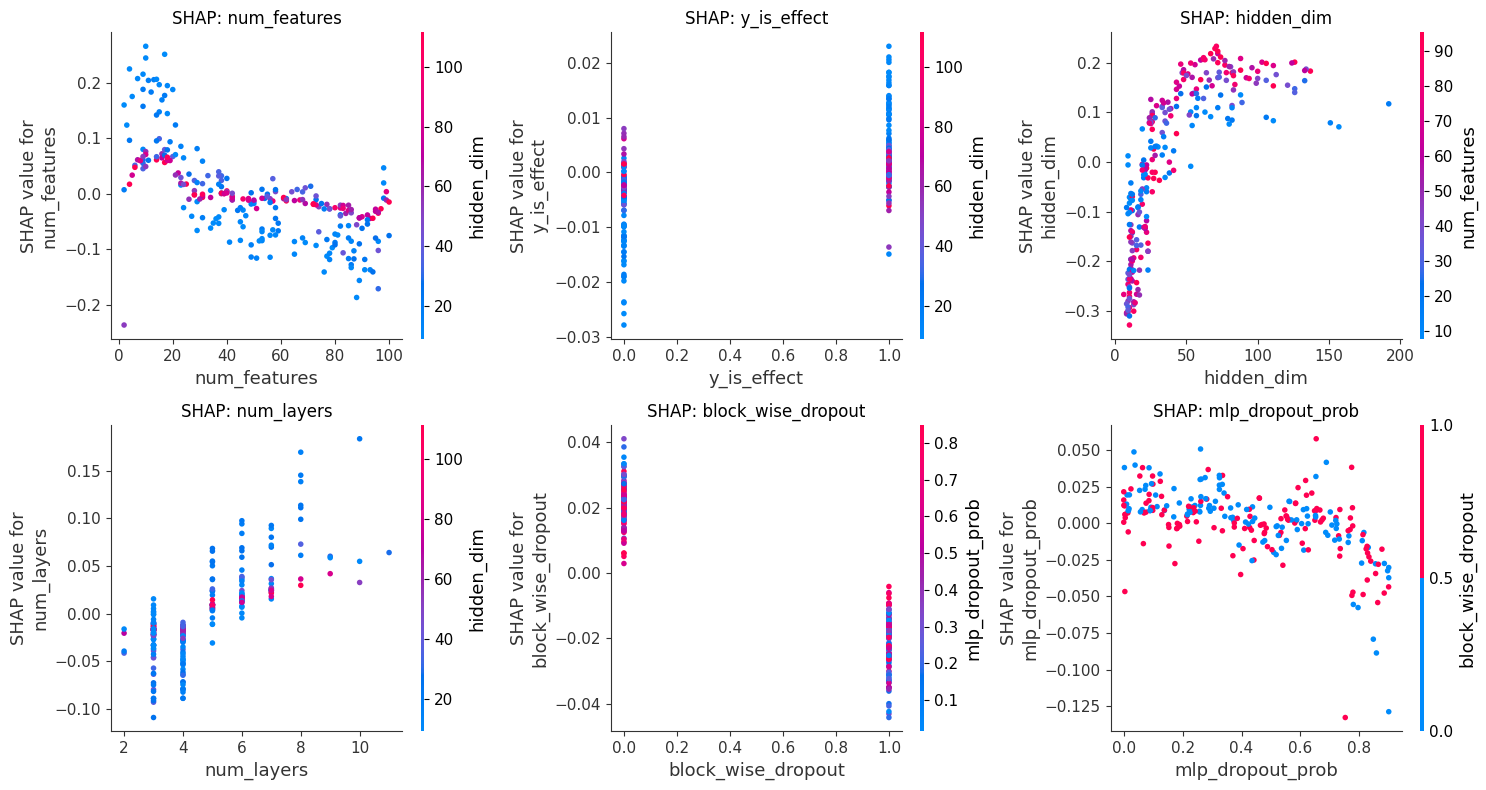

In [11]:
# Settings
cols_per_row = 3
n_features = X.shape[1]
n_rows = math.ceil(n_features / cols_per_row)

# Create a big figure
fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(15, 4 * n_rows))
axes = axes.flatten() # Flatten 2D grid to 1D list for easy looping

for i, col_name in enumerate(X.columns):
    # shap.dependence_plot usually handles the plot creation, 
    # we pass 'ax' to tell it where to draw.
    shap.dependence_plot(
        col_name, 
        shap_values, 
        X, 
        ax=axes[i], 
        show=False, 
        interaction_index='auto' # Automatically picks the feature with strongest interaction to color by
    )
    axes[i].set_title(f"SHAP: {col_name}")

# Hide any empty subplots if features don't fill the last row
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

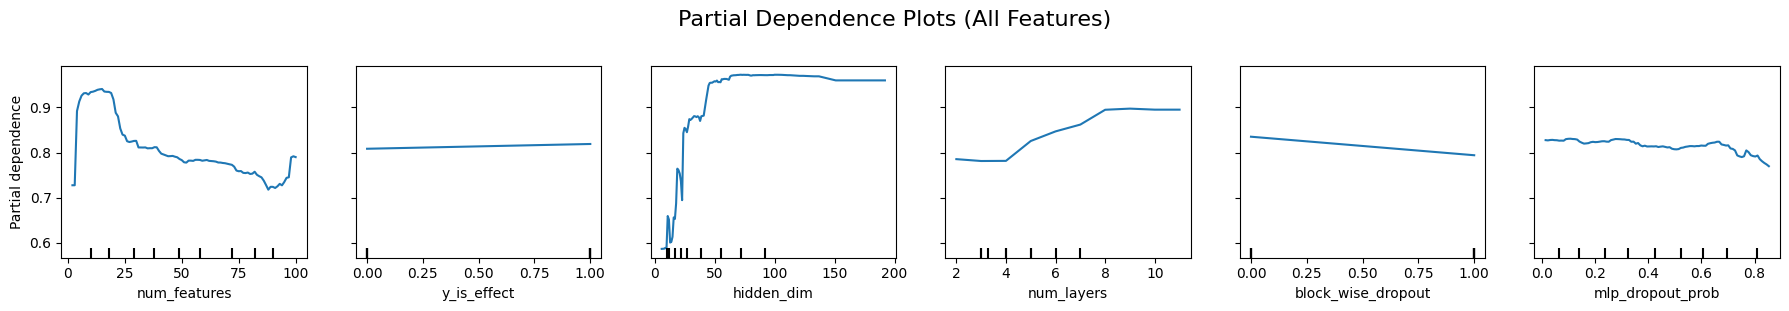

In [12]:
n_features = len(X.columns)

fig, ax = plt.subplots(figsize=(3*n_features, 3))

PartialDependenceDisplay.from_estimator(
    model, 
    X, 
    features=X.columns,  # Pass ALL columns here
    ax=ax, 
    kind='average',
    n_cols=n_features        # How many columns in the grid
)

plt.suptitle("Partial Dependence Plots (All Features)", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


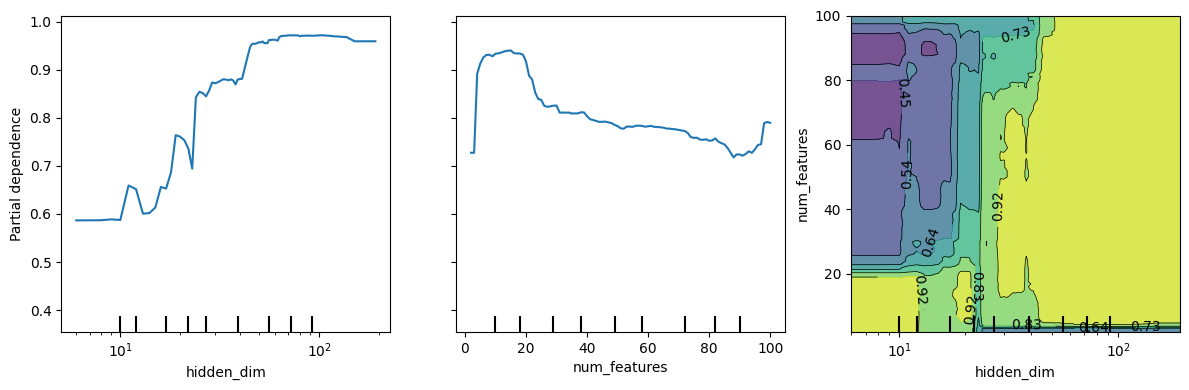

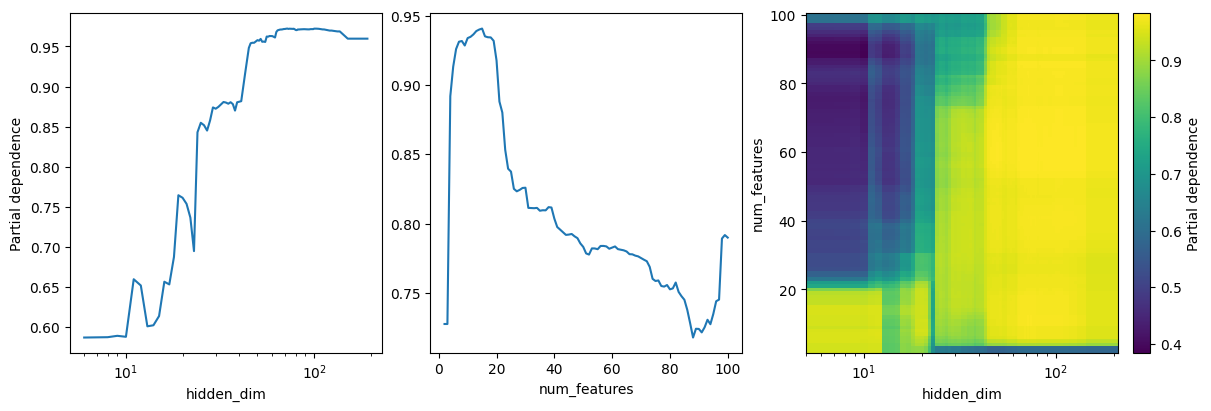

In [13]:
def plot_custom_pdp_easy(model, X, feat_x, feat_y, log_x=False, log_y=False):
    """
    General PDP plotter using PartialDependenceDisplay.
    feat_x: first feature (plotted on index 0 and as X in interaction)
    feat_y: second feature (plotted on index 1 and as Y in interaction)
    """
    fig, ax = plt.subplots(figsize=(12, 4))

    pdp = PartialDependenceDisplay.from_estimator(
        model, 
        X, 
        features=[
            feat_x,
            feat_y,
            (feat_x, feat_y),
        ],
        ax=ax, 
        kind='average',
    )

    ax_inter = pdp.axes_[0, 2]
    if log_x:
        pdp.axes_[0, 0].set_xscale('log')
        ax_inter.set_xscale('log')
    if log_y:
        pdp.axes_[0, 1].set_xscale('log')
        ax_inter.set_yscale('log')

    plt.tight_layout()
    plt.show()


def plot_custom_pdp(model, X, feat_x, feat_y, log_x=False, log_y=False):
    """
    Plots two 1D Partial Dependence plots and one 2D interaction heatmap.
    
    Parameters:
    - feat_x, feat_y: Strings of the feature names.
    - log_x, log_y: Booleans to determine if the axis should be logarithmic.
    """
    # 1. Calculate dependencies
    pdp_x = partial_dependence(model, X, features=[feat_x], kind='average')
    pdp_y = partial_dependence(model, X, features=[feat_y], kind='average')
    pdp_inter = partial_dependence(model, X, features=[feat_x, feat_y], kind='average')

    # 2. Setup Figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

    # --- Plot 1: feat_x (1D) ---
    ax1.plot(pdp_x['grid_values'][0], pdp_x['average'][0])
    ax1.set_xlabel(feat_x)
    ax1.set_ylabel('Partial dependence')

    # --- Plot 2: feat_y (1D) ---
    ax2.plot(pdp_y['grid_values'][0], pdp_y['average'][0])
    ax2.set_xlabel(feat_y)

    # --- Plot 3: Interaction Heatmap (2D) ---
    XX, YY = np.meshgrid(pdp_inter['grid_values'][0], pdp_inter['grid_values'][1])
    Z = pdp_inter['average'][0].T
    mesh = ax3.pcolormesh(XX, YY, Z, shading='auto', cmap='viridis')
    ax3.set_xlabel(feat_x)
    ax3.set_ylabel(feat_y)

    cbar = fig.colorbar(mesh, ax=ax3)
    cbar.set_label('Partial dependence')

    if log_x:
        ax1.set_xscale('log')
        ax3.set_xscale('log')
    
    if log_y:
        ax2.set_xscale('log')
        ax3.set_yscale('log')

    plt.show()

    return fig, (ax1, ax2, ax3)

plot_custom_pdp_easy(model, X, feat_x = 'hidden_dim', feat_y = 'num_features', log_x=True, log_y=False);
plot_custom_pdp(model, X, feat_x = 'hidden_dim', feat_y = 'num_features', log_x=True, log_y=False);


In [14]:
df_parallel = df_encoded.copy()

bool_cols = df_parallel.select_dtypes(include=['bool']).columns
for col in bool_cols:
    df_parallel[col] = df_parallel[col].astype(int)

fig = px.parallel_coordinates(
    df_parallel, 
    color="density",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show()

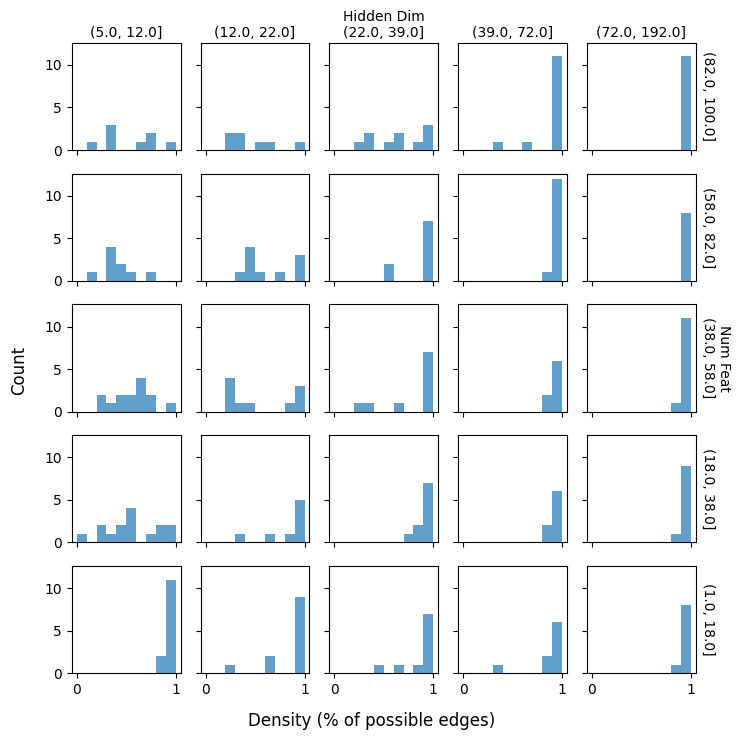

In [15]:
df = df_encoded.copy()

# num_features_bins = np.linspace(0, 100, 6, endpoint=True)
# hidden_dim_bins = np.linspace(0, 135, 6, endpoint=True)

# assert df['num_features'].max() <= num_features_bins[-1], "num_features exceeds the maximum bin limit"
# assert df['hidden_dim'].max() <= hidden_dim_bins[-1], "hidden_dim exceeds the maximum bin limit"

# # Create categorical columns based on bins
# df['num_features_bucket'] = pd.cut(df['num_features'], bins=num_features_bins, 
#                                      labels=[f'{num_features_bins[i]}-{num_features_bins[i+1]}' 
#                                             for i in range(len(num_features_bins)-1)])
# df['hidden_dim_bucket'] = pd.cut(df['hidden_dim'], bins=hidden_dim_bins,
#                                   labels=[f'{hidden_dim_bins[i]}-{hidden_dim_bins[i+1]}' 
#                                          for i in range(len(hidden_dim_bins)-1)])

# num_features_buckets = df['num_features_bucket'].cat.categories
# hidden_dim_buckets = df['hidden_dim_bucket'].cat.categories

df['num_features_bucket'] = pd.qcut(df['num_features'], q=5, duplicates='drop', precision = 0)
df['hidden_dim_bucket'] = pd.qcut(df['hidden_dim'], q=5, duplicates='drop', precision = 0)

# Get the unique categories (Intervals) sorted
num_features_buckets = sorted(df['num_features_bucket'].unique(), reverse=True)
hidden_dim_buckets = sorted(df['hidden_dim_bucket'].unique())

density_bins = np.linspace(0, 1, 11)

figsize = 1.5
nrows, ncols = len(num_features_buckets), len(hidden_dim_buckets)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                        figsize=(figsize*ncols, figsize*nrows), 
                        squeeze=False, sharex=True, sharey=True)

for i, num_features_bucket in enumerate(num_features_buckets):
    for j, hidden_dim_bucket in enumerate(hidden_dim_buckets):
        ax = axs[i, j]
        
        mask = (df['hidden_dim_bucket'] == hidden_dim_bucket) & \
               (df['num_features_bucket'] == num_features_bucket)
        densities = df[mask]['density']
        ax.hist(densities, bins=density_bins, alpha=0.7)
        

for j, hidden_dim_bucket in enumerate(hidden_dim_buckets):
    hidden_dim_title = f'Hidden Dim\n{hidden_dim_bucket}' if j == len(hidden_dim_buckets)//2 else f"{hidden_dim_bucket}"
    ax = axs[0, j]
    ax.xaxis.set_label_position("top")
    ax.set_xlabel(hidden_dim_title, fontsize=10)

for i, num_features_bucket in enumerate(num_features_buckets):
    num_features_title = f'Num Feat\n{num_features_bucket}' if i == len(num_features_buckets)//2 else f"{num_features_bucket}"
    ax = axs[i, -1]
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(num_features_title, fontsize=10, rotation = -90, va = 'bottom')


fig.supxlabel('Density (% of possible edges)', y=0.02)
fig.supylabel('Count', x=0.03, ha = 'center')
plt.tight_layout()
plt.show()

# g = sns.FacetGrid(
#     df, 
#     row="num_features_bucket", 
#     col="hidden_dim_bucket", 
#     row_order=num_features_buckets,
#     col_order=hidden_dim_buckets,
#     margin_titles=True,
#     height=1.5,
#     aspect=1.0, 
#     despine=False,
# )

# # 3. Map Histogram
# density_bins = np.linspace(0, 1, 11)
# g.map(plt.hist, "density", bins=density_bins, alpha=0.7)
# g.set_axis_labels("", "")
# g.set_titles(col_template="{col_name}", row_template="{row_name}")

# m = 0.90
# g.fig.subplots_adjust(top=m, right=m)#, left=1-m, bottom=1-m)
# g.fig.text(0.5, 0.96, 'Hidden Dim', ha='center', va='center', fontsize=11)
# g.fig.text(0.98, 0.5, 'Num Feat', ha='center', va='center', rotation=-90, fontsize=11)

# g.fig.supxlabel('Density (% of possible edges)', y=0.02)
# g.fig.supylabel('Count', x=0.03, ha = 'center')

# plt.show()
